In [3]:
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier
import graphviz

from IPython.display import Image

%matplotlib inline

# Load Data

In [4]:
data_train = np.loadtxt('svm-train.txt')
data_test = np.loadtxt('svm-test.txt')
X_train, y_train = data_train[:, 0: 2], data_train[:, 2].reshape(-1, 1)
X_test, y_test = data_test[:, 0: 2], data_test[:, 2].reshape(-1, 1)

In [5]:
# Change target to 0-1 label
y_train_label = np.array(list(map(lambda x: 1 if x > 0 else 0, y_train))).reshape(-1, 1)

# Decision Tree Class

In [6]:
def compute_entropy(label_array):
    '''
    Calulate the entropy of given label list
    
    :param label_array: a numpy array of binary labels shape = (n, 1)
    :return entropy: entropy value
    '''
    # Your code goes here
    label_array = np.array(label_array).flatten()
    n_classes = np.unique(label_array)
    entropy = 0
    length = len(label_array)
    for label in n_classes:
        countDict = Counter(label_array)
        p = countDict[label]/length
        entropy += -p*np.log(p)
    return entropy

def compute_gini(label_array):
    '''
    Calulate the gini index of label list
    
    :param label_array: a numpy array of labels shape = (n, 1)
    :return gini: gini index value
    '''
    # Your code goes here
    label_array = np.array(label_array).flatten()
    n_classes = np.unique(label_array)
    gini = 0
    length = len(label_array)
    for label in n_classes:
        countDict = Counter(label_array)
        p = countDict[label]/length
        gini += p*(1-p)
    return gini

In [17]:
class Decision_Tree(BaseEstimator):

    def __init__(self, split_loss_function, leaf_value_estimator,
                 depth=0, min_sample=5, max_depth=10):
        '''
        Initialize the decision tree classifier

        :param split_loss_function: method with args X returning loss
        :param leaf_value_estimator: method for estimating leaf value from array of ys
        :param depth: depth indicator, default value is 0, representing root node
        :param min_sample: an internal node can be splitted only if it contains points more than min_smaple
        :param max_depth: restriction of tree depth.
        '''
        self.split_loss_function = split_loss_function
        self.leaf_value_estimator = leaf_value_estimator
        self.depth = depth
        self.min_sample = min_sample
        self.max_depth = max_depth
        self.is_leaf = True
        # Node Info
        self.value = None
        self.split_id = None
        self.split_value = None
        self.split_index = None
        self.left = None
        self.right = None

    def fit(self, X, y):
        '''
        This should fit the tree classifier by setting the values self.is_leaf, 
        self.split_id (the index of the feature we want ot split on, if we're splitting),
        self.split_value (the corresponding value of that feature where the split is),
        and self.value, which is the prediction value if the tree is a leaf node.  If we are 
        splitting the node, we should also init self.left and self.right to be Decision_Tree
        objects corresponding to the left and right subtrees. These subtrees should be fit on
        the data that fall to the left and right,respectively, of self.split_value.
        This is a recurisive tree building procedure. 

        :param X: a numpy array of training data, shape = (n, m)
        :param y: a numpy array of labels, shape = (n, 1)

        :return self
        '''
        # Your code goes here
        n, m = X.shape

        if self.depth == self.max_depth or n <= self.min_sample:
            self.value = self.leaf_value_estimator(y)
            return self

        best_loss = self.split_loss_function(y)
        best_split_index = None
        best_split_id = None
        combine = np.concatenate([X, y], axis=1)
        for i in range(m):
            combine = np.array(sorted(combine, key=lambda x: x[i]))        
            y = np.array(combine[:, -1]).reshape(-1, 1)
            split_index, loss = self.find_best_split(y)
            if loss < best_loss:
                self.is_leaf = False
                best_loss = loss
                best_split_index = split_index
                best_split_id = i

        if self.is_leaf:
            self.value = self.leaf_value_estimator(y)
        else:
            combine = np.array(sorted(combine, key=lambda x: x[best_split_id]))
            X = np.array(combine[:, :-1])
            y = np.array(combine[:, -1]).reshape(-1, 1)
            self.split_id = best_split_id
            self.split_value = X[best_split_index - 1, best_split_id]
            self.split_index = best_split_index - 1
            self.left = Decision_Tree(self.split_loss_function, self.leaf_value_estimator, self.depth + 1,
                                        self.min_sample, self.max_depth)
            self.right = Decision_Tree(self.split_loss_function, self.leaf_value_estimator, self.depth + 1,
                                        self.min_sample, self.max_depth)
            self.left.fit(X[:best_split_index], y[:best_split_index])
            self.right.fit(X[best_split_index:], y[best_split_index:])
        return self

    def find_best_split(self, y):
        '''
        For specific feature, returns the optimal splitting point 
        for data X, y, and corresponding loss
        :param y: a numpy array of labels, shape = (n_node, 1)
        '''
        # Your code
        n = y.shape[0]
        best_loss = np.inf
        split_index = 0
        for i in range(n - 1):
            loss_left = (i + 1) * self.split_loss_function(y[:i + 1]) / n
            loss_right = (n - i - 1) * self.split_loss_function(y[i + 1:]) / n
            loss_total = loss_left + loss_right
            if loss_total < best_loss:
                best_loss = loss_total
                split_index = i + 1
        return split_index, best_loss

    def find_best_feature_split(self, X, y):
        '''
        Returns the optimal feature to split and best splitting point 
        for data X_node, y_node.
        :param X: a numpy array of training data, shape = (n_node, m_feature)
        :param y: a numpy array of labels, shape = (n_node, 1)
        '''
        # The code is in the fit method, this function is redundant, it will call
        # find_best_split but cannot return the new loss, and best split value
        pass

    def predict_instance(self, instance):
        '''
        Predict label by decision tree

        :param instance: a numpy array with new data, shape (1, m)

        :return whatever is returned by leaf_value_estimator for leaf containing instance
        '''
        if self.is_leaf:
            return self.value
        if instance[self.split_id] <= self.split_value:
            return self.left.predict_instance(instance)
        else:
            return self.right.predict_instance(instance)

    def print(self):
        if self.is_leaf:
            print("leafV: ", self.value)
        else:
            print("feature: ", self.split_id, "splitV: ", self.split_value, "splitI: ", self.split_index)
            self.left.print()
            self.right.print()


In [18]:
def most_common_label(y):
    '''
    Find most common label
    '''
    label_cnt = Counter(y.reshape(len(y)))
    label = label_cnt.most_common(1)[0][0]
    return label

# Decision Tree Classifier

In [19]:
def most_common_label(y):
    '''
    Find most common label
    '''
    label_cnt = Counter(y.reshape(len(y)))
    label = label_cnt.most_common(1)[0][0]
    return label

In [20]:
class Classification_Tree(BaseEstimator, ClassifierMixin):

    loss_function_dict = {
        'entropy': compute_entropy,
        'gini': compute_gini
    }

    def __init__(self, loss_function='entropy', min_sample=5, max_depth=10):
        '''
        :param loss_function(str): loss function for splitting internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                most_common_label,
                                0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

    def print(self):
        self.tree.print()

# Decision Tree Boundary

feature:  0 splitV:  -1.8773682961015312 splitI:  55
feature:  1 splitV:  -2.77823717940671 splitI:  4
feature:  1 splitV:  -2.824045140643922 splitI:  3
leafV:  1.0
leafV:  0.0
leafV:  1.0
feature:  0 splitV:  1.8644088044471103 splitI:  96
feature:  1 splitV:  -1.7000975268739043 splitI:  26
leafV:  1.0
leafV:  0.0
feature:  1 splitV:  -3.1940819634007607 splitI:  5
leafV:  1.0
leafV:  1.0


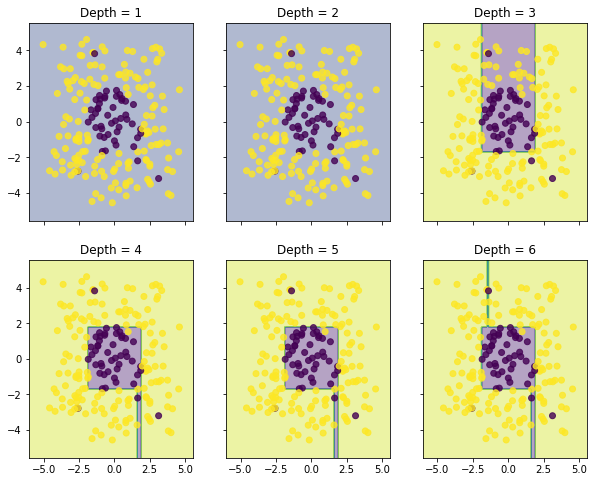

In [21]:
# Training classifiers with different depth
clf1 = Classification_Tree(max_depth=1, min_sample=2)
clf1.fit(X_train, y_train_label)

clf2 = Classification_Tree(max_depth=2, min_sample=2)
clf2.fit(X_train, y_train_label)

clf3 = Classification_Tree(max_depth=3, min_sample=2)
clf3.fit(X_train, y_train_label)
clf3.print()
clf4 = Classification_Tree(max_depth=4, min_sample=2)
clf4.fit(X_train, y_train_label)

clf5 = Classification_Tree(max_depth=5, min_sample=2)
clf5.fit(X_train, y_train_label)

clf6 = Classification_Tree(max_depth=6, min_sample=2)
clf6.fit(X_train, y_train_label)

# Plotting decision regions
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    Z = np.array([clf.predict_instance(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X_train[:, 0], X_train[:, 1], c=y_train_label[:,0], alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

# Compare decision tree with tree model in sklearn

In [10]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=2)
clf.fit(X_train, y_train_label)
export_graphviz(clf, out_file='tree_classifier.dot')

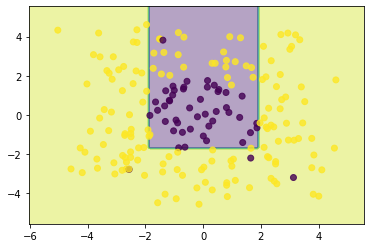

In [11]:
# Plotting decision regions
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = np.array([clf.predict(x[np.newaxis,:]) for x in np.c_[xx.ravel(), yy.ravel()]])
Z = Z.reshape(xx.shape)
plt.figure()
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_train[:, 0], X_train[:, 1], 
c=y_train_label[:,0], alpha=0.8)

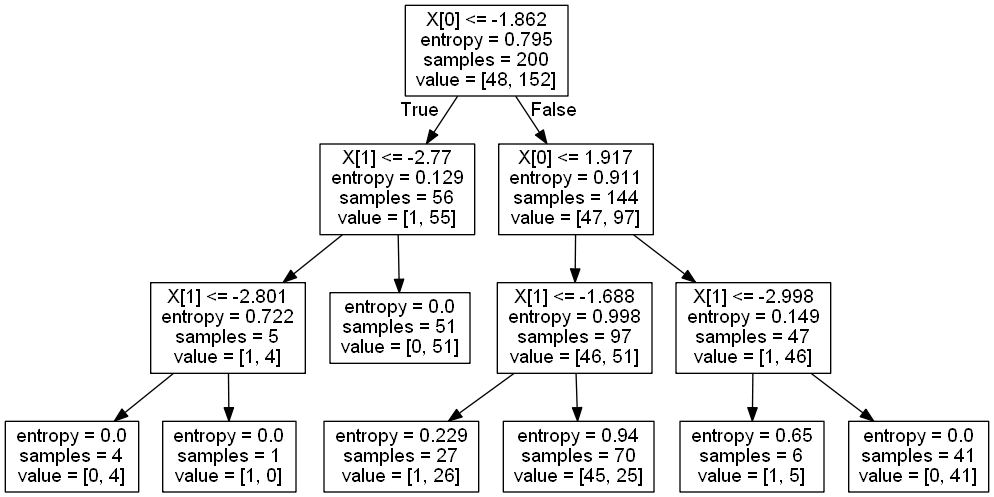

In [12]:
# Visualize decision tree
!dot -Tpng tree_classifier.dot -o tree_classifier.png
Image(filename='tree_classifier.png')

# Decision Tree Regressor

In [13]:
# Regression Tree Specific Code
def mean_absolute_deviation_around_median(y):
    '''
    Calulate the mean absolute deviation around the median of a given target list
    
    :param y: a numpy array of targets shape = (n, 1)
    :return mae
    '''
    # Your code goes here
    median = np.median(y)
    mae = np.mean(np.abs(y - median))
    return mae

In [14]:
class Regression_Tree():
    '''
    :attribute loss_function_dict: dictionary containing the loss functions used for splitting
    :attribute estimator_dict: dictionary containing the estimation functions used in leaf nodes
    '''

    loss_function_dict = {
        'mse': np.var,
        'mae': mean_absolute_deviation_around_median
    }

    estimator_dict = {
        'mean': np.mean,
        'median': np.median
    }
    
    def __init__(self, loss_function='mse', estimator='mean', min_sample=5, max_depth=10):
        '''
        Initialize Regression_Tree
        :param loss_function(str): loss function used for splitting internal nodes
        :param estimator(str): value estimator of internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                  self.estimator_dict[estimator],
                                  0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Fit regression tree to one-dimensional regression data

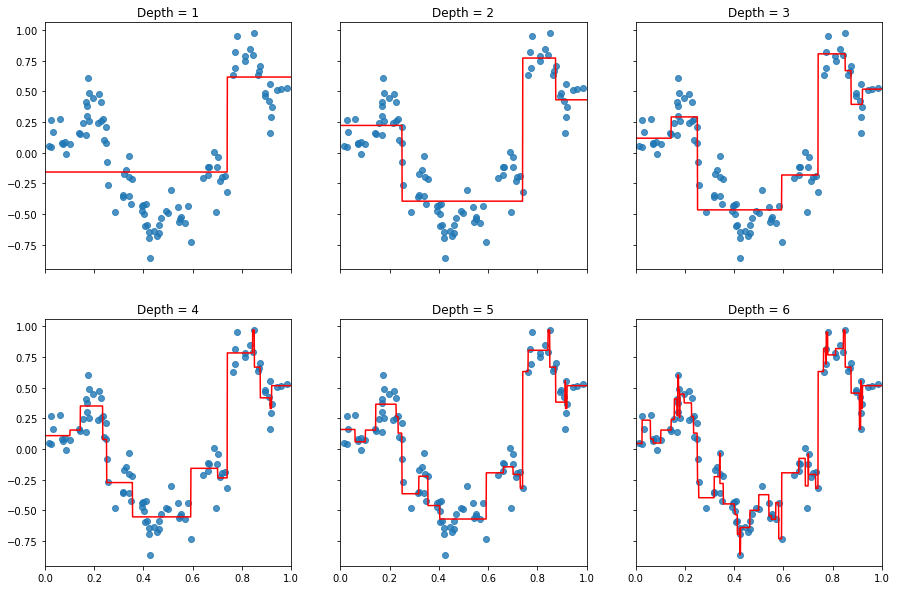

In [15]:
data_krr_train = np.loadtxt('krr-train.txt')
data_krr_test = np.loadtxt('krr-test.txt')
x_krr_train, y_krr_train = data_krr_train[:,0].reshape(-1,1),data_krr_train[:,1].reshape(-1,1)
x_krr_test, y_krr_test = data_krr_test[:,0].reshape(-1,1),data_krr_test[:,1].reshape(-1,1)

# Training regression trees with different depth
clf1 = Regression_Tree(max_depth=1,  min_sample=3, loss_function='mae', estimator='mean')
clf1.fit(x_krr_train, y_krr_train)

clf2 = Regression_Tree(max_depth=2,  min_sample=3, loss_function='mae', estimator='mean')
clf2.fit(x_krr_train, y_krr_train)

clf3 = Regression_Tree(max_depth=3,  min_sample=3, loss_function='mae', estimator='mean')
clf3.fit(x_krr_train, y_krr_train)

clf4 = Regression_Tree(max_depth=4,  min_sample=3, loss_function='mae', estimator='mean')
clf4.fit(x_krr_train, y_krr_train)

clf5 = Regression_Tree(max_depth=5,  min_sample=3, loss_function='mae', estimator='mean')
clf5.fit(x_krr_train, y_krr_train)

clf6 = Regression_Tree(max_depth=10,  min_sample=3, loss_function='mae', estimator='mean')
clf6.fit(x_krr_train, y_krr_train)

plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    y_range_predict = np.array([clf.predict_instance(x) for x in x_range]).reshape(-1, 1)
  
    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)
plt.show()

# Gradient Boosting Method

In [16]:
#Pseudo-residual function.

def pseudo_residual_L2(train_target, train_predict):
    '''
    Compute the pseudo-residual based on current predicted value. 
    '''
    return train_target - train_predict

In [17]:
class gradient_boosting():
    '''
    Gradient Boosting regressor class
    :method fit: fitting model
    '''

    def __init__(self, n_estimator, pseudo_residual_func, learning_rate=0.01,
                 min_sample=5, max_depth=5):
        '''
        Initialize gradient boosting class

        :param n_estimator: number of estimators (i.e. number of rounds of gradient boosting)
        :pseudo_residual_func: function used for computing pseudo-residual between training labels and predicted labels at each iteration
        :param learning_rate: step size of gradient descent
        '''
        self.n_estimator = n_estimator
        self.pseudo_residual_func = pseudo_residual_func
        self.learning_rate = learning_rate
        self.min_sample = min_sample
        self.max_depth = max_depth

        self.estimators = []  # will collect the n_estimator models

    def fit(self, train_data, train_target):
        '''
        Fit gradient boosting model
        :train_data array of inputs of size (n_samples, m_features) 
        :train_target array of outputs of size (n_samples,) 
        '''
        X, y = train_data, train_target
        n, m = train_data.shape
        for _ in range(self.n_estimator):
            y_acc = np.zeros(n)
            for i in range(len(self.estimators)):
                for j in range(n):
                    y_acc[j] += self.learning_rate * \
                        self.estimators[i].predict_instance(X[j])
            rt = Regression_Tree(
                min_sample=self.min_sample, max_depth=self.max_depth, loss_function='mse', estimator='mean')
            rt.fit(X, self.pseudo_residual_func(y, y_acc).reshape(-1, 1))
            self.estimators.append(rt)

    def predict(self, test_data):
        '''
        Predict value
        :train_data array of inputs of size (n_samples, m_features)
        '''
        # Your code goes here
        X = test_data
        test_predict = np.zeros(len(X))
        for i in range(self.n_estimator) :
            for j in range(len(X)) :
                test_predict[j] += self.learning_rate * self.estimators[i].predict_instance(X[j])
        return test_predict


# 1-D GBM visualization - KRR data

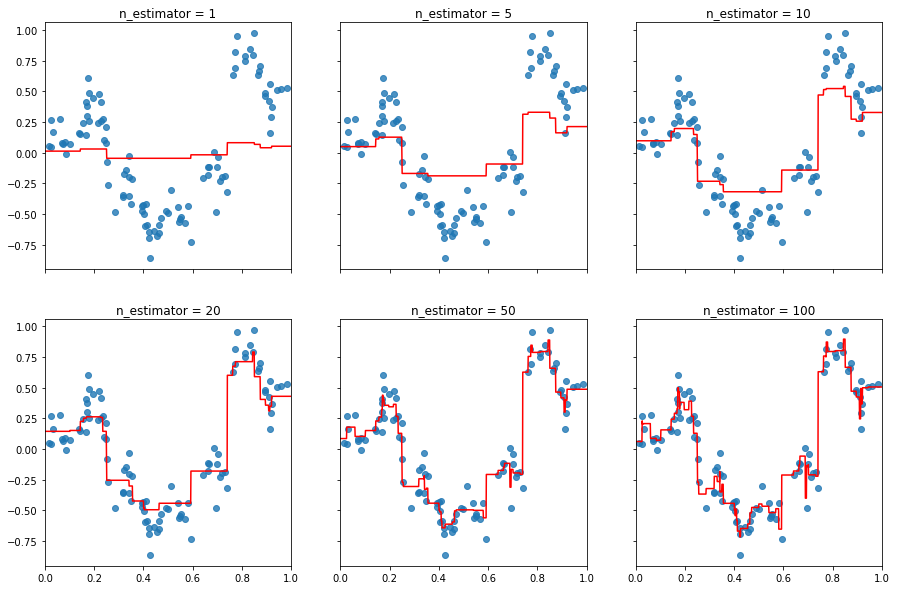

In [18]:
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbm_1d = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, 
                               max_depth=3, learning_rate=0.1)  
    gbm_1d.fit(x_krr_train, y_krr_train[:,0])
    
    y_range_predict = gbm_1d.predict(x_range)

    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)

# Sklearn implementation for Classification of images

In [19]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state


In [20]:
def pre_process_mnist_01():
    """
    Load the mnist datasets, selects the classes 0 and 1 
    and normalize the data.
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    X_mnist, y_mnist = fetch_openml('mnist_784', version=1, 
                                    return_X_y=True, as_frame=False)
    indicator_01 = (y_mnist == '0') + (y_mnist == '1') 
    X_mnist_01 = X_mnist[indicator_01]
    y_mnist_01 = y_mnist[indicator_01]
    X_train, X_test, y_train, y_test = train_test_split(X_mnist_01, y_mnist_01,
                                                        test_size=0.33,
                                                        shuffle=False)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_test = scaler.transform(X_test)

    y_test = 2 * np.array([int(y) for y in y_test]) - 1
    y_train = 2 * np.array([int(y) for y in y_train]) - 1
    return X_train, X_test, y_train, y_test

In [21]:
X_train, X_test, y_train, y_test = pre_process_mnist_01()

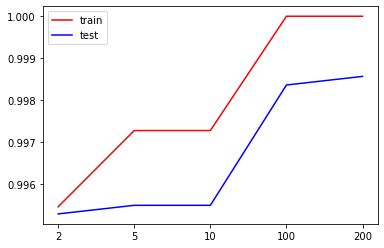

In [22]:
from sklearn import metrics
accuracy_test = np.zeros(5)
accuracy_train = np.zeros(5)
for idx, i in enumerate([2, 5, 10, 100, 200]): 
    gbc = GradientBoostingClassifier(n_estimators=i, loss='deviance')
    gbc.fit(X_train, y_train)
    accuracy_test[idx] = metrics.accuracy_score(y_test, gbc.predict(X_test))
    accuracy_train[idx] = metrics.accuracy_score(y_train, gbc.predict(X_train))
plt.plot(np.arange(0,5,1), accuracy_train, c='r', label='train')
plt.plot(np.arange(0,5,1), accuracy_test, c='b', label='test')
plt.xticks(np.arange(0,5,1), [2, 5, 10, 100, 200])
plt.legend()

# Random Forests

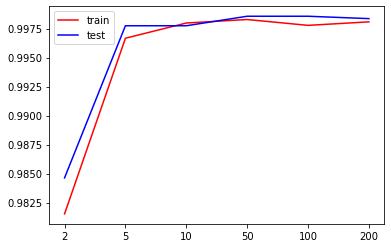

In [23]:
accuracy_test = np.zeros(6)
accuracy_train = np.zeros(6)
for idx, i in enumerate([2, 5, 10, 50, 100, 200]): 
    gbc = RandomForestClassifier(n_estimators=i, max_depth=3, criterion='entropy')
    gbc.fit(X_train, y_train)
    accuracy_test[idx] = metrics.accuracy_score(y_test, gbc.predict(X_test))
    accuracy_train[idx] = metrics.accuracy_score(y_train, gbc.predict(X_train))
plt.plot(np.arange(0,6,1), accuracy_train, c='r', label='train')
plt.plot(np.arange(0,6,1), accuracy_test, c='b', label='test')
plt.xticks(np.arange(0,6,1), [2, 5, 10, 50, 100, 200])
plt.legend()
